In [1]:
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
images_path = '../images/'

## Testing Image

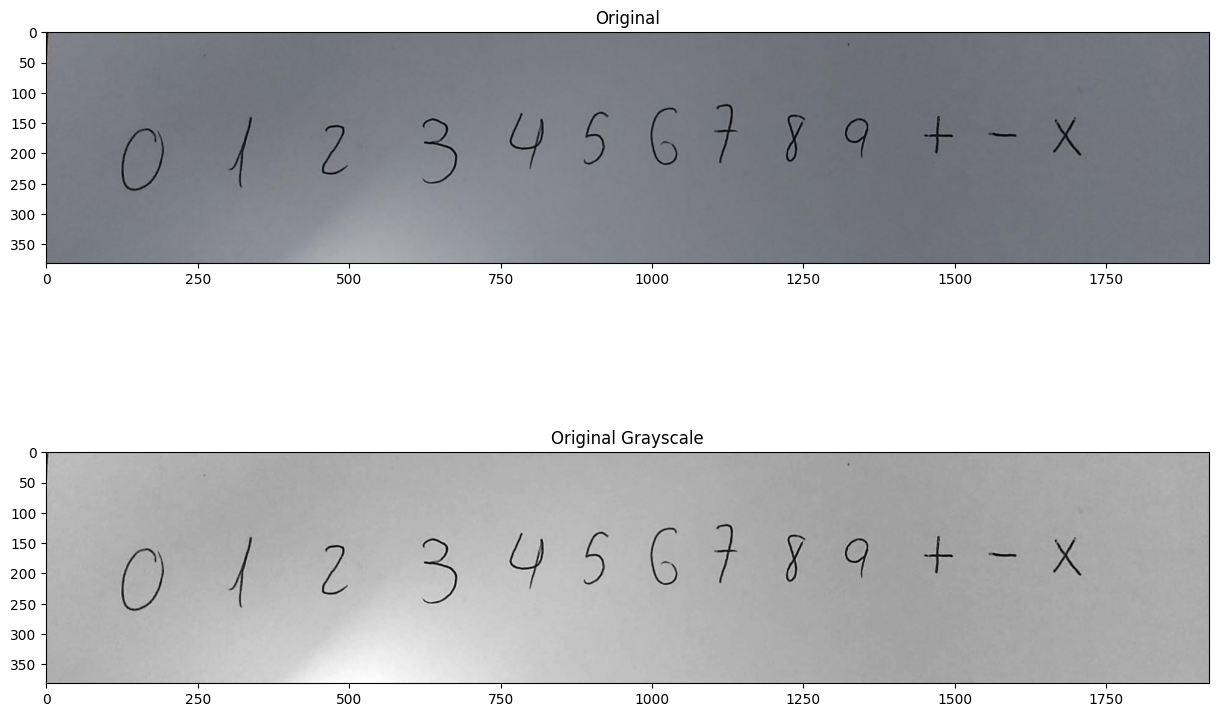

In [2]:
image = cv2.imread(images_path + "test10.jpeg",-1)
image_color = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

plt.subplot(2,1,1)
plt.title("Original")
plt.imshow(image_color)

plt.subplot(2,1,2)
plt.title("Original Grayscale")
plt.imshow(image_grey,cmap='grey')


## AUX METHODS

In [3]:
def gaussian_bell1D(x, sigma):
    base = 1 / (sigma * np.sqrt(2 * np.pi))
    exp = np.exp(-(x * x) / (2 * (sigma * sigma)))

    return base * exp


def gaussian_filter(image, w_kernel, sigma):
    # Create kernel using associative property
    s = sigma
    w = w_kernel
    kernel_1D = np.float32([gaussian_bell1D(z, s) for z in range(-w, w + 1)])  # Evaluate the gaussian in "expression"
    vertical_kernel = kernel_1D.reshape(2 * w + 1, 1)  # Reshape it as a matrix with just one column
    horizontal_kernel = kernel_1D.reshape(1, 2 * w + 1)  # Reshape it as a matrix with just one row
    kernel = signal.convolve2d(vertical_kernel, horizontal_kernel)  # Get the 2D kernel

    # Convolve image and kernel
    smoothed_img = cv2.filter2D(image, cv2.CV_8U, kernel)
    return smoothed_img

In [4]:
def binarize_kmeans(image, it):
    # Set random seed for centroids
    cv2.setRNGSeed(124)

    # Flatten image
    flattened_img = image.reshape((-1, 1))
    flattened_img = np.float32(flattened_img)

    # Set epsilon
    epsilon = 0.2

    # Establish stopping criteria (either `it` iterations or moving less than `epsilon`)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)

    # Set K parameter (2 for thresholding)
    K = 2

    # Call kmeans using random initial position for centroids
    _, label, center = cv2.kmeans(flattened_img, K, None, criteria, it, cv2.KMEANS_RANDOM_CENTERS)

    # Colour resultant labels
    center = np.uint8(center)  # Get center coordinates as unsigned integers
    center[0] = 0
    center[1] = 255
    flattened_img = center[label.flatten()]  # Get the color (center) assigned to each pixel

    # Reshape vector image to original shape
    binarized = flattened_img.reshape(image.shape)

    return binarized

In [5]:
def binarize_em(image,it):
    cv2.setRNGSeed(5)
    # Define parameters
    n_clusters = 2
    covariance_type = 0  # 0: covariance matrix spherical. 1: covariance matrix diagonal. 2: covariance matrix generic
    epsilon = 0.2
    # Create EM empty object
    em = cv2.ml.EM_create()
    # Set parameters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, it, epsilon)
    em.setClustersNumber(n_clusters)
    em.setCovarianceMatrixType(covariance_type)
    em.setTermCriteria(criteria)
    # Flatten image
    flattened_img = image.reshape((-1, 1))
    flattened_img = np.float32(flattened_img)
    # Apply EM
    _, _, labels, _ = em.trainEM(flattened_img)
    # Reshape labels to image size (binarization)
    binarized = labels.reshape((image.shape))
    return binarized

## GAUSSIAN FILTERING & CLAHE

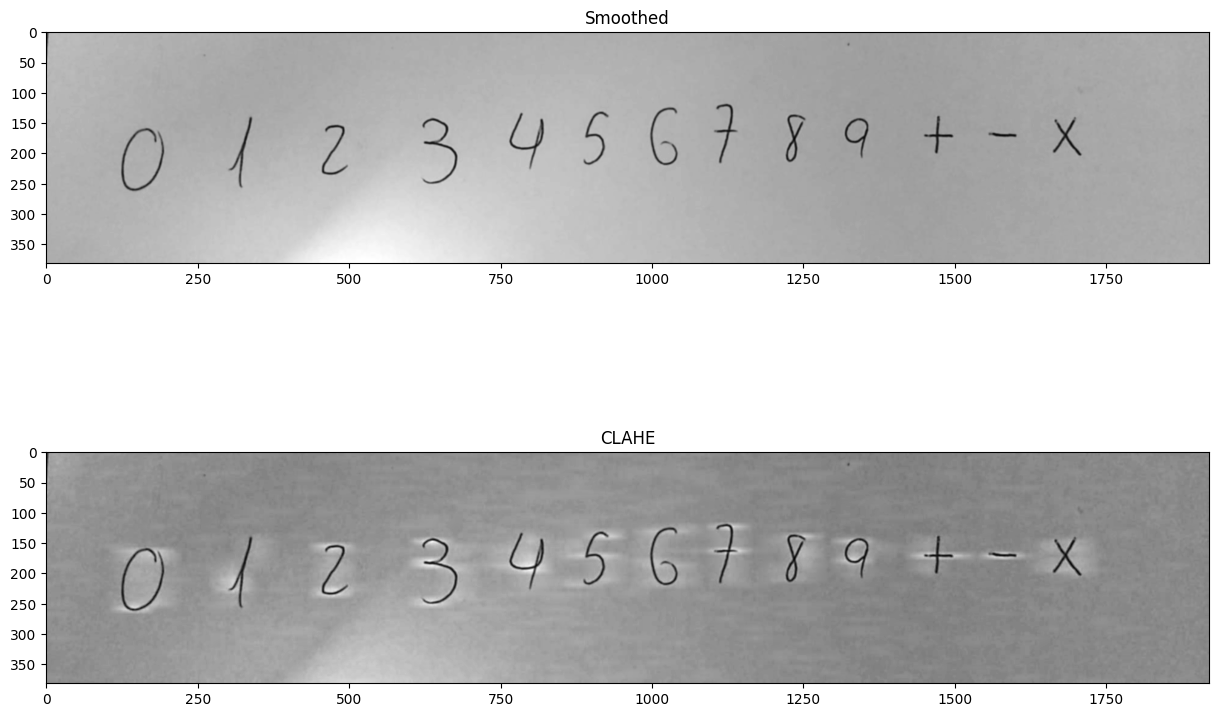

In [6]:
smoothed_image = gaussian_filter(image_grey,4,1)

clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(48, 48))
enhanced_smoothed = clahe.apply(smoothed_image)

plt.subplot(2,1,1)
plt.title("Smoothed")
plt.imshow(smoothed_image,cmap='grey')

plt.subplot(2,1,2)
plt.title("CLAHE")
plt.imshow(enhanced_smoothed,cmap='grey')

plt.show()

## KMEANS AND EM

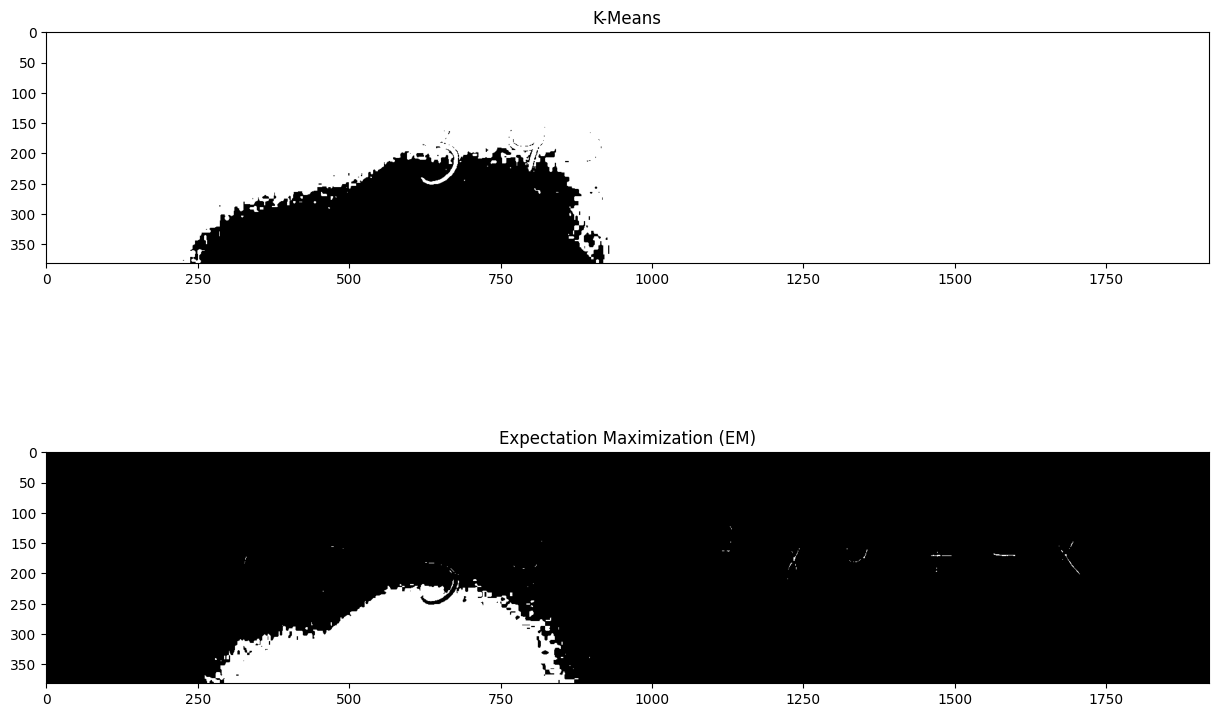

In [7]:
kmeans_image = binarize_kmeans(smoothed_image,5)
em_image = binarize_em(smoothed_image,5)

plt.subplot(2,1,1)
plt.title("K-Means")
plt.imshow(kmeans_image,cmap='grey')

plt.subplot(2,1,2)
plt.title("Expectation Maximization (EM)")
plt.imshow(em_image,cmap='grey')

plt.show()

## HISTOGRAMS